In [180]:
# Import Sequences

from Bio.Seq import Seq
from Bio import SeqIO

sc1g = SeqIO.read('data/sars_cov_1_genome.fasta', 'fasta')
sc2g = SeqIO.read('data/sars_cov_2_genome.fasta', 'fasta')

print('Length of Sars-Cov-1 Genome: {}'.format(len(sc1g)))
print('Length of Sars-Cov-2 Genome: {}'.format(len(sc1g)))

Length of Sars-Cov-1 Genome: 29751
Length of Sars-Cov-2 Genome: 29751


In [181]:
# Some Library code for Analysis

import os
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
from Bio import SeqIO
from Bio.Align import substitution_matrices

def seqsim(alignfile):
    blosum62 = substitution_matrices.load("BLOSUM62")

    # basedir = '/Users/davidwang/projects/sarscov2/data'
    # seq1 = SeqIO.read('{}/sars_cov_2_e_prot.fasta'.format(basedir), 'fasta')
    # seq2 = SeqIO.read('{}/mers_cov_e_prot.fasta'.format(basedir), 'fasta')
    # aligns = pairwise2.align.globalds(seq1.seq, seq2.seq, blosum62, -10, -0.5)

    # Read in Sequences Aligned by MAFFT
    aligndata = open(alignfile).read()
    seqs = aligndata.split('>')
    seq1 = ''.join(seqs[1].split('\n')[1:])
    seq2 = ''.join(seqs[2].split('\n')[1:])
    
    return {
        'seq1': seq1,
        'seq2': seq2,
        'similarity': similarity_score(seq1, seq2),
    }

def cdna_to_rna(dna):
    return str(dna).replace('T', 'U')

def similarity_score(ref, seq):
    similar = 0
    
    for i in range(len(ref)):
        if ref[i] == seq[i]:
            similar += 1

    return similar / len(ref)

def plot_protein_sim(data):
    width = 0.25
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    proteins = ['E Protein', 'M Protein', 'N Protein', 'S Protein']
    locs = np.arange(len(data[0]))
    
    ax.set_ylabel('% Sequence  Similarity')
    ax.set_title('Sequence Similarity to Sars-Cov-2')
    
    plt.bar(locs, data[0], color='g', width=width, label=proteins[0])
    plt.bar(locs+width, data[1], color='b', width=width, label=proteins[0])
    plt.xticks(range(len(proteins)), proteins)
    plt.yticks(np.arange(0, 101, 10))
    ax.legend(labels=['Mers-Cov 2012', 'Sars-Cov 2004'])
    
    plt.show()

In [183]:
# Calculate Protein Sequence Similarity Between Sars-Cov, Sars-Cov2, and Mers-Cov

proteins = ['e', 'm', 'n', 's']
sim_results = [[], []]

basedir = '/Users/davidwang/projects/sarscov2/data'
for p in proteins:
    alignfile = '{}/sars_cov_2_mers_cov_{}_prot.ali'.format(basedir, p)
    result = seqsim(alignfile)
    sim_results[0].append(result['similarity']*100)

    basename = os.path.basename(alignfile)
    print('{} Protein Length: {} Similarity: {:.1f}%'.format(basename, len(result['seq1']), result['similarity']*100))
    
for p in proteins:
    alignfile = '{}/sars_cov_2_sars_cov_1_{}_prot.ali'.format(basedir, p)
    result = seqsim(alignfile)
    sim_results[1].append(result['similarity']*100)
    
    basename = os.path.basename(alignfile)
    print('{} Protein Length: {} Similarity: {:.1f}%'.format(basename, len(result['seq1']), result['similarity']*100))

sars_cov_2_mers_cov_e_prot.ali Protein Length: 82 Similarity: 35.4%
sars_cov_2_mers_cov_m_prot.ali Protein Length: 223 Similarity: 40.4%
sars_cov_2_mers_cov_n_prot.ali Protein Length: 450 Similarity: 45.8%
sars_cov_2_mers_cov_s_prot.ali Protein Length: 1451 Similarity: 30.5%
sars_cov_2_sars_cov_1_e_prot.ali Protein Length: 76 Similarity: 94.7%
sars_cov_2_sars_cov_1_m_prot.ali Protein Length: 222 Similarity: 90.5%
sars_cov_2_sars_cov_1_n_prot.ali Protein Length: 422 Similarity: 90.5%
sars_cov_2_sars_cov_1_s_prot.ali Protein Length: 1277 Similarity: 76.0%


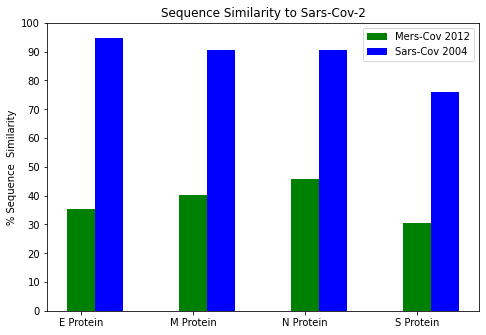

In [184]:
# Plot Protein Sequence Similarity Between Sars-Cov, Sars-Cov2, and Mers-Cov
plot_protein_sim(sim_results)

In [187]:
import pandas as pd

df = pd.read_csv('data/200938383919-sars_cov_vipr_epitopes.tsv', sep='\t')

In [279]:
# ViPR Epitope Analysis

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7150947/

# Total Number of Epitopes 1394
# Positive T cell assays                                         | T cell epitopes              | 115
# Positive major histocompatibility complex (MHC) binding assays | T cell epitopes              | 959
# Positive B cell assays                                         | Linear B cell epitopes       | 298
#                                                                | Discontinuous B cell epitopes| 6
# ----------------------------------------------------------------------------------------------------
#                                                                | Total                        |1378

# Selection Criteria
# 1. human hosts.
# 2. Only experimentally-determined epitopes associated with at least one positive assay.
# 3. Positive B cell assays (e.g., enzyme-linked immunosorbent assay (ELISA)-based qualitative binding) for B cell epitopes.
# 4. Positive T cell assays 
#      - enzyme-linked immune absorbent spot (ELISPOT)
#      - Intracellular cytokine staining (ICS) IFN-γ release)
#      - Positive major histocompatibility complex (MHC) binding assays for T cell epitopes.

assay_dict = {
    'B Cell': 0,
    'T Cell': 0,
    'MHC Binding' : 0,
}

epitopes = []
for row in df.itertuples():
    human_indicies = [i for i, x in enumerate(row[4].split(',')) if x == 'Human'] # Hosts
    assay_types = row[5].split(',') # Assay Types
    results = row[6].split(',') # Assay Results ['Positive', 'Negative', etc]
    methods = row[9].split(',') # Methods
    positive_indicies = [i for i in human_indicies if 'Positive' in results[i]]
    at_least_one_positive = len(positive_indicies) > 0
    
    for i in human_indicies:
        if not at_least_one_positive:
            continue
            
        if assay_types[i] == 'B Cell' and methods[i] == 'ELISA':
            assay_dict[assay_types[i]] += 1
            break
  
        if assay_types[i] in ['T Cell', 'MHC Binding'] and methods[i] in [
             'ELISPOT',
             'ICS',
             'cellular MHC/competitive/fluorescence',
             'cellular MHC/direct/fluorescence',
             'purified MHC',
             'purified MHC/competitive/fluorescence',
             'purified MHC/competitive/radioactivity',
             'purified MHC/direct/fluorescence',
             'purified MHC/direct/radioactivity',
        ]:
            assay_dict[assay_types[i]] += 1
            break
            
assay_dict

{'B Cell': 268, 'T Cell': 27, 'MHC Binding': 959}

In [1]:
seq_ids = [
 'YP_005352862.1',
 'AMN91620.1',
 'YP_002308478.1',
 'P0C6Y5.1',
 'APD51497.1',
 'AVA26872.1',
 'AKJ21970.1',
 'YP_001718610.1',
 'AHB63507.1',
 'AAS00078.1',
 'ACV87277.1',
 'YP_009555238.1',
 'YP_209229.2',
 'ARB07596.1',
 'ATG84853.1',
 'ABN10847.1',
 'AAP33696.1',
 'AVP25405.1',
]

In [2]:
from Bio import Entrez
from Bio import SeqIO
Entrez.email = 'something@something.com'

seqs = {}
for s_id in seq_ids:
    handle = Entrez.efetch(db='protein', id=s_id, rettype='gb', retmode='text')
    seq = SeqIO.read(handle, 'genbank')
    seqs[s_id] = seq

In [155]:
SeqIO.write(seqs, 'all.faa', 'fasta')

18

In [181]:
with open('clustalo.clustal_num') as f:
    data = f.readlines()

In [186]:
"""
Got the following error when using consurf:

"The uploaded MSA file, which appears to be in clustalw format, contains non-standard characters: "J". 
To fix the format please replace all non-standard characters with standard characters
(gaps : "-" Amino Acids : "A" , "C" , "D" .. "Y") and resubmit your query."

This is because we have a 'J' amino acid in on line 998 in our clustalo.clustal_num multi alignment file

'ATG84853.1          GTPNEKLVTTSTAPDFVAFNVFQGIETAVGHYVHARLKGGJILKFDSGTVSKTSDWKCKV	1788' 

Apparently a 'J' is supposed to indicate either 'I' or 'L'.
We will replace with an 'L' in this case because ABN10847.1 and AVP25405.1 have 'L's in that position
which is the majority.
"""

# Replace ambiguous amino acids with the majority e.g. J -> L because J can be either I or L.
# def replace_ambiguous_aa(rows):
#     for i, r in enumerate(rows):
#         cols = r.split()
#         align = cols[1] if len(cols) > 2 else ''
#         if 'J' in align:
#             row = cols[1].replace('J', 'L')
            
# replace_ambiguous_aa(data)
# open('clustalo_unique_aa.clustal_num', 'w').write(''.join(data))

239485

In [284]:
'''
Get Accession IDs for Sars-Cov-2 Genomes https://www.pnas.org/content/117/17/9241?cct=2302
Paper: Phylogenetic network analysis of SARS-CoV-2 genomes
'''

import csv

ids = []
with open('data/other/forster/2b Cluster assignments-Table 1.csv') as file:
    reader = csv.reader(file)
    
    for i, row in enumerate(reader):
        if i > 3:
            ids.append(row[3])
            
print(ids)

['EPI_ISL_402123', 'EPI_ISL_406798', 'EPI_ISL_402119', 'EPI_ISL_402128', 'EPI_ISL_402129', 'EPI_ISL_402130', 'EPI_ISL_403930', 'EPI_ISL_402121', 'EPI_ISL_402132', 'EPI_ISL_412898', 'EPI_ISL_412899', 'EPI_ISL_402124', 'EPI_ISL_403931', 'EPI_ISL_403929', 'EPI_ISL_402127', 'EPI_ISL_402125', 'EPI_ISL_402120', 'EPI_ISL_406800', 'EPI_ISL_408514', 'EPI_ISL_408515', 'EPI_ISL_403928', 'EPI_ISL_406716', 'EPI_ISL_406717', 'EPI_ISL_406801', 'EPI_ISL_411957', 'EPI_ISL_412459', 'EPI_ISL_403962', 'EPI_ISL_406030', 'EPI_ISL_405839', 'EPI_ISL_408486', 'EPI_ISL_410301', 'EPI_ISL_406593', 'EPI_ISL_403963', 'EPI_ISL_403932', 'EPI_ISL_403933', 'EPI_ISL_403934', 'EPI_ISL_403935', 'EPI_ISL_408484', 'EPI_ISL_404227', 'EPI_ISL_406594', 'EPI_ISL_406595', 'EPI_ISL_403936', 'EPI_ISL_404228', 'EPI_ISL_404228', 'EPI_ISL_412978', 'EPI_ISL_408480', 'EPI_ISL_403937', 'EPI_ISL_412979', 'EPI_ISL_412980', 'EPI_ISL_412981', 'EPI_ISL_408481', 'EPI_ISL_408485', 'EPI_ISL_404895', 'EPI_ISL_407313', 'EPI_ISL_408482', 'EPI_ISL_